<a href="https://colab.research.google.com/github/sokrypton/laxy/blob/main/examples/gremlin_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -qnc https://raw.githubusercontent.com/sokrypton/laxy/main/laxy.py

In [ ]:
import laxy
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import string

# parse msa

In [ ]:
def parse_fasta(filename, a3m=False):
  '''function to parse fasta file'''
  
  if a3m:
    # for a3m files the lowercase letters are removed
    # as these do not align to the query sequence
    rm_lc = str.maketrans(dict.fromkeys(string.ascii_lowercase))
    
  header, sequence = [],[]
  lines = open(filename, "r")
  for line in lines:
    line = line.rstrip()
    if line[0] == ">":
      header.append(line[1:])
      sequence.append([])
    else:
      if a3m: line = line.translate(rm_lc)
      else: line = line.upper()
      sequence[-1].append(line)
  lines.close()
  sequence = [''.join(seq) for seq in sequence]
  
  return header, sequence
  
def mk_msa(seqs):
  '''one hot encode msa'''
  alphabet = "ARNDCQEGHILKMFPSTWYV-"
  states = len(alphabet)  
  a2n = {a:n for n,a in enumerate(alphabet)}
  msa_ori = np.array([[a2n.get(aa, states-1) for aa in seq] for seq in seqs])
  return np.eye(states)[msa_ori]

In [ ]:
from scipy.spatial.distance import pdist, squareform
def get_eff(msa, eff_cutoff=0.8):
  if msa.ndim == 3: msa = msa.argmax(-1)    
  # pairwise identity  
  msa_sm = 1.0 - squareform(pdist(msa,"hamming"))
  # weight for each sequence
  msa_w = (msa_sm >= eff_cutoff).astype(np.float)
  msa_w = 1/np.sum(msa_w,-1)
  
  return msa_w

# gremlin

In [ ]:
class GREMLIN:
  '''GREMLIN implemented in jax'''
  
  def __init__(self, X, W=None, batch_size=None, lam=0.01):
    N,L,A = X.shape
    self.X = jnp.array(X)
    self.W = jnp.array(W) if W is not None else None
    self.batch_size = batch_size

    if batch_size is None:
      learning_rate = 0.1 * np.log(N)/L
    else:
      lam *= batch_size/N
      learning_rate = 0.1 * jnp.log(batch_size)/L

    # setup the model
    def model(params, inputs):
      y_logits, w = laxy.MRF(params)(inputs["x"], return_w=True)
      out = jax.nn.softmax(y_logits)

      # categorical-crossentropy (or pseudo-likelihood)
      cce_loss = -(inputs["x"]*jnp.log(out+1e-8)).sum([1,2])

      # weight each example
      if self.W is not None: cce_loss *= inputs["w"]

      # regularization
      l2_loss = 0.5*(L-1)*(A-1)*jnp.square(w).sum() 
      l2_loss += jnp.square(params["b"]).sum()

      loss = cce_loss.sum() + lam * l2_loss
      return out, loss

    # initialize model params
    params = laxy.MRF()(L=L,A=A)

    # initialize bias using mean of data
    b_ini = np.log(np.sum(X,0) + 0.01 * np.log(N))
    params["b"] = jnp.array(b_ini - np.mean(b_ini,-1,keepdims=True))

    # setup optimizer
    self.opt = laxy.OPT(model, params, lr=learning_rate)

  def get_w(self):
    w = self.opt.get_params()["w"]
    rm_diag = (1-jnp.eye(w.shape[0]))[:,None,:,None]
    w = w * rm_diag
    return np.array((w + w.transpose([2,3,0,1]))/2)
    
  def fit(self, steps=100, verbose=True, return_losses=False):
    '''train model'''
    if self.W is None: inputs = {"x":self.X}
    else: inputs = {"x":self.X,"w":self.W}

    losses = self.opt.fit(inputs, steps=steps, batch_size=self.batch_size,
                         verbose=verbose, return_losses=return_losses)
    if return_losses: return losses

#example

In [ ]:
!wget -qnc https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/4FAZA.fas

In [ ]:
names, seqs = parse_fasta("4FAZA.fas")
msa = mk_msa(seqs)
msa_weights = get_eff(msa)
print(msa.shape)

(817, 62, 21)


In [ ]:
model = GREMLIN(msa, msa_weights, batch_size=None)

In [ ]:
%%time
model.fit()

10 31093.637
20 28594.41
30 27666.285
40 27281.223
50 27105.771
60 27021.943
70 26976.688
80 26949.621
90 26931.875
100 26919.34
CPU times: user 635 ms, sys: 79.2 ms, total: 714 ms
Wall time: 507 ms


In [ ]:
%%time
# note if you run fit again, it will continue optimization
# the first time was a little slower due to compile time
model.fit()

10 26910.025
20 26902.922
30 26897.398
40 26893.037
50 26889.562
60 26886.777
70 26884.512
80 26882.662
90 26881.148
100 26879.883
CPU times: user 105 ms, sys: 64.1 ms, total: 169 ms
Wall time: 155 ms


In [ ]:
W = model.get_w()

In [ ]:
def get_mtx(W):
  # l2norm of 20x20 matrices (note: we ignore gaps)
  raw = np.sqrt(np.sum(np.square(W[:,:20,:,:20]),(1,3)))
  np.fill_diagonal(raw,0)

  # apc (average product correction)
  ap = np.sum(raw,0,keepdims=True)*np.sum(raw,1,keepdims=True)/np.sum(raw)
  apc = raw - ap
  np.fill_diagonal(apc,0)
  
  return(raw,apc)

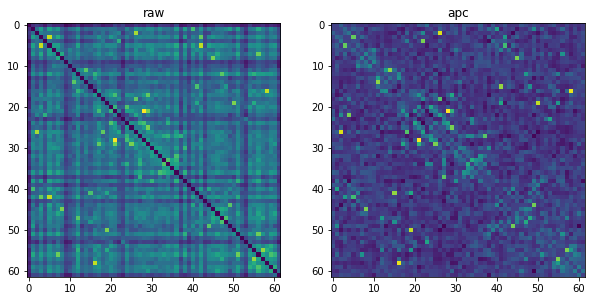

In [ ]:
raw, apc = get_mtx(W)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1);plt.title("raw");plt.imshow(raw)
plt.subplot(1,2,2);plt.title("apc");plt.imshow(apc)
plt.show()